Title: Introduction to Convolutional Networks
Author: Thomas Breuel
Institution: UniKL

In [2]:

from pylab import *
from scipy.ndimage import filters
def F(a): return array(a,'f')

# A Nonlinear Image Processing Problem

Let's start by constructing a simple non-linear image processing filter. Can we learn this filter?



0.91207802

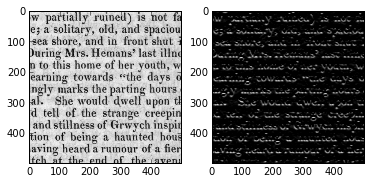

In [5]:
image = 1.0*(mean(imread("page.png"),2))
roi = (slice(500,1000),slice(500,1000))
image = image[roi]
image -= mean(image)
out = 1.0*(8*maximum(0,filters.gaussian_filter(image,2.0,order=(1,0))))
gray()
subplot(121); imshow(image)
subplot(122); imshow(out)
amax(out)

# Learning a Linear Filter

Note that if this were a linear filter, we might think we can derive it from the Fourier transform:

convolution (linear filter):

$$y = f * x$$

fundamental theorem:

$${\cal F}[y] = {\cal F}[f] \cdot {\cal F}[x]$$

solving the equation:

$${\cal F}[f] = \frac{{\cal F}[y]}{{\cal F}[x]}$$

transforming back:

$$ f =  {\cal F}^{-1} \left[ \frac{ {\cal F}[y] } { {\cal F}[x] } \right] $$

However, this may or may not be the filter we want.


In [14]:

def sigmoid(x): return 1/(1+exp(-x))

# Single Layer Convolutional Neural Network

The simplest convolutional neural network has no hidden layer; it is the equivalent
of a sigmoid regression.  The formula is:

$$ Y = \sigma(F*X+\theta) $$

Here

- $F$ is the filter
- $X$ is the input image
- $Y$ is the cleaned up output
- $\theta$ is a threshold

Now, we can view the convolution basically as a large number of independent
training problems.  

Consider the image $I_\hat{p}$, which is the image
$I$ shifted by $-p$.  If we keep the filter fixed and shift the image,
then the output $C$ at pixel $p$ is given by:

$$Y(p) = F \cdot X_{\hat{p}} + \theta$$

Generally, the filter $F$ has a small footprint, meaning that
it is zero outside a small region around the origin.

In essence, this problem is just like training with lots of separate
training instances, except that we're trying to use a convolution
operation to implement this.
We need to keep track of the coordinates in the right way.

$$
\begin{eqnarray}
\frac{\partial}{\partial F_{ij}} \sum_p (~T(p)-Y(p)~)^2 &=& \sum_p 2(T(p)-Y(p)) ~~ \sigma'(F\cdot I_{\hat{p}}) ~~ I_{\hat{p}}\\\
&=&\sum_p 2(T(p)-Y(p)) ~~ Y(p)(1-Y(p)) ~~ I_{\hat{p},i,j}
\end{eqnarray}
$$

Here, we define $\delta(p)$ as before:

$$ \delta(p) =  2(T(p)-Y(p)) ~~ Y(p)(1-Y(p)) $$

Let's generate a random mask to start with.



In [7]:
r=5
filter = F(0.01*randn(2*r+1,2*r+1))

Now let's look at the output this filter generates.



(0.48624954, 0.52211583)

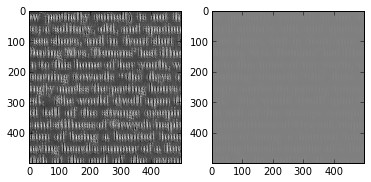

In [8]:
pred = sigmoid(filters.convolve(image,filter))
subplot(121); imshow(pred)
subplot(122); imshow(pred,vmin=0,vmax=1)
amin(pred),amax(pred)

As before, we compute a delta between the output and the desired output.



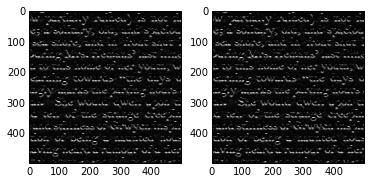

In [10]:
delta0 = (out-pred)
subplot(121); imshow(delta0)
delta = (out-pred)*pred*(1-pred)
subplot(122); imshow(delta)

Note that each weight in our random filter contributes to all output pixels.
If we want to "backpropagate" the deltas, we need to sum up all the deltas from all the filter outputs.



(-0.0034652944, 0.0011683544, dtype('float32'))

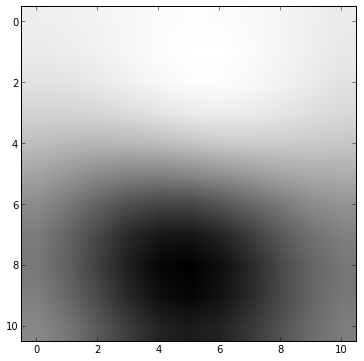

In [90]:
dw = array([[sum(delta*roll(roll(image,i,0),j,1)) for j in range(-r,r+1)] for i in range(-r,r+1)])
dw /= prod(image.shape)
imshow(dw)
amin(dw),amax(dw),dw.dtype

Let's put this all together into a gradient descent learning algorithm. 



In [11]:
theta = 0.0
for iter in range(1000):
    pred = sigmoid(filters.convolve(image,filter)+theta)
    err = sum((pred-out)**2)
    delta = (pred-out)*pred*(1-pred)
    delta /= prod(image.shape)
    dw = array([[sum(delta*roll(roll(image,i,0),j,1)) for j in range(-r,r+1)] for i in range(-r,r+1)])
    if iter%50==0:
        print iter,err,":",(amin(pred),amax(pred)),sum(abs(delta)),
        print (amin(dw),amax(dw)),(amin(filter),amax(filter)),theta
    filter -= dw
    theta -= sum(delta)

0 51495.0 : (0.48624954, 0.52211583) 0.10982 (-0.0013520373, 0.0032668943) (-0.029455993, 0.026091032) 0.0
50 4397.94 : (0.072140738, 0.36709112) 0.0162744 (-0.00070879137, 0.0011495821) (-0.10338775, 0.063890524) -1.71587491222
100 2627.21 : (0.031862784, 0.45811501) 0.0103208 (-0.00061922497, 0.00093237666) (-0.15040764, 0.088849939) -2.03730937187
150 1910.8 : (0.017386325, 0.56336188) 0.00819295 (-0.00056234887, 0.00077779568) (-0.18951969, 0.11478845) -2.19306036993
200 1473.71 : (0.010572175, 0.65190011) 0.00688511 (-0.00050368829, 0.0006372091) (-0.2218695, 0.13822004) -2.29702537518
250 1181.12 : (0.006968664, 0.71730405) 0.00591087 (-0.00044778202, 0.00052048423) (-0.24828075, 0.16170618) -2.37981959002
300 977.117 : (0.0049024085, 0.76385123) 0.00515023 (-0.00039510831, 0.00043040476) (-0.26993901, 0.18278031) -2.45108571986
350 829.998 : (0.0036344689, 0.79730797) 0.0045502 (-0.00034930339, 0.0003636154) (-0.28797349, 0.20138238) -2.51411203877
400 720.586 : (0.002809946, 0.

After this training, let's look at the output.



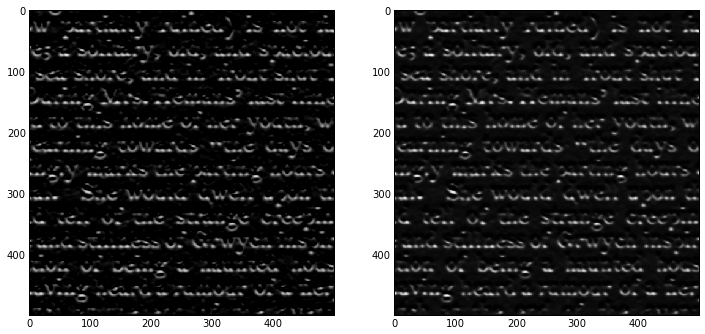

In [12]:
figsize(12,6)
subplot(121); imshow(out,interpolation='nearest')
subplot(122); imshow(pred,interpolation='nearest')

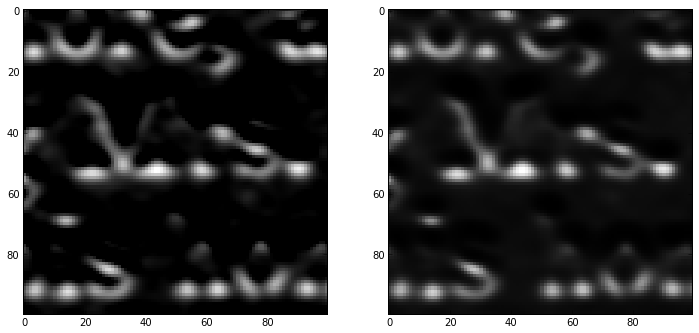

In [13]:
figsize(12,6)
subplot(121); imshow(out[100:200,100:200],interpolation='nearest')
subplot(122); imshow(pred[100:200,100:200],interpolation='nearest')

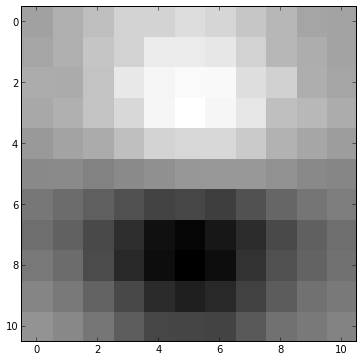

In [93]:
imshow(filter,interpolation='nearest')